# Imports

In [1]:
import pyarrow as pa
import pyarrow.parquet as pq

import pandas as pd

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
import numpy as np

import geopandas as gpd #heatmap

# Data loading

### BTC data

In [2]:
btc_price_data = pd.read_csv("data/BTC_ALL_graph_coinmarketcap.csv",sep=";")

#split off time of day
btc_price_data["timestamp"] = btc_price_data["timestamp"].apply(lambda x: str(x).split("T")[0]) 
btc_price_data = btc_price_data[["high", "timestamp"]]
btc_price_data.rename(columns={"timestamp": "date"}, inplace=True)


btc_price_data["year"] = btc_price_data["date"].apply(lambda x: int(str(x).split("-")[0]))

btc_price_data = btc_price_data[btc_price_data['year'] >= 2011]

display(btc_price_data.tail())

,high,date,year
726,26550.072937,2023-05-04,2023
727,25148.010374,2023-05-11,2023
728,25338.472061,2023-05-17,2023
729,25279.405768,2023-05-24,2023
730,26131.181703,2023-05-30,2023


### Actors data

In [3]:
actors = pq.read_table("data/actors.parquet")
actors_df = actors.to_pandas()

actors_df

,id,uri,label,jurisdictions,categories
0,bilaxy,bilaxy.com,Bilaxy,HK,exchange
1,banxa,banxa.com,Banxa,"AU, NL, US",exchange
2,aax,www.aax.com,Aax,SC,exchange
3,altcointrader,www.altcointrader.co.za,AltcoinTrader,ZA,exchange
4,azbit,azbit.com,Azbit,MH,exchange
...,...,...,...,...,...
309,stocksexchange,stex.com,Stex,EE,exchange
310,smenarnabitcoin,smenarnabitcoin.cz,Smenarnabitcoin,CZ,exchange
311,xapo,xapo.com,Xapo,US,"exchange, service"
312,yobit,yobit.net,YoBit,RU,exchange


### Flow data

In [4]:
flows = pq.read_table("data/flows.parquet")
flows_df = flows.to_pandas()

flows_df

,src_id,dst_id,value_asset,value_USD,date
0,1coin,1coin,36870000,243.755870,2014-03-03
1,1coin,1coin,380120000,2378.899210,2014-03-10
2,1coin,1coin,429150403,2738.687542,2014-03-13
3,1coin,1coin,333900098,2092.574397,2014-03-14
4,1coin,1coin,779334803,4938.373652,2014-03-15
...,...,...,...,...,...
1939582,zyado,zyado,1019592,11.368847,2017-03-21
1939583,zyado,zyado,1004152,13.325487,2017-04-29
1939584,zyado,zyado,39850720,5966.967603,2018-01-10
1939585,zyado,zyado,19251202,1730.115174,2018-04-27


### Country Codes

In [5]:
# Load country codes (source: https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes)
country_codes = pd.read_csv('data/country_codes.csv')

display(country_codes.head())

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN


### GDP (PPP) Data

In [6]:
# Load GDP data (PPP) (Source: https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD)
gdp = pd.read_csv('data/gdp.csv', skiprows=3)
gdp_meta = pd.read_csv('data/gdp_meta.csv')

display(gdp.head())
display(gdp_meta.head())

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Unnamed: 67
0,Aruba,ABW,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,36846.848285,37343.912963,37583.840323,38865.188195,41679.238190,42501.641554,34971.009913,42698.359872,NaN,NaN
1,Africa Eastern and Southern,AFE,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3470.550675,3498.125396,3591.099809,3635.564622,3724.868177,3777.972368,3621.058106,3839.470058,NaN,NaN
2,Afghanistan,AFG,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2110.829568,2128.125938,2023.834656,2096.093111,2109.929296,2167.704111,2076.138380,1665.805842,NaN,NaN
3,Africa Western and Central,AFW,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4143.177054,4075.994459,3998.951876,4045.303263,4160.540965,4264.731035,4174.504565,4409.450961,NaN,NaN
4,Angola,AGO,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,8123.048065,7274.090475,7027.146634,7216.061373,7042.923829,6881.076241,6362.636076,6491.125578,NaN,NaN


,Country Code,Region,IncomeGroup,SpecialNotes,TableName,Unnamed: 5
0,ABW,Latin America & Caribbean,High income,NaN,Aruba,NaN
1,AFE,NaN,NaN,"26 countries, stretching from the Red Sea in t...",Africa Eastern and Southern,NaN
2,AFG,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,NaN
3,AFW,NaN,NaN,"22 countries, stretching from the westernmost ...",Africa Western and Central,NaN
4,AGO,Sub-Saharan Africa,Lower middle income,The World Bank systematically assesses the app...,Angola,NaN


### Population data

In [7]:
# Load Population data (Source: https://data.worldbank.org/indicator/SP.POP.TOTL)
population = pd.read_csv('data/population.csv', skiprows=3)

display(population.head())

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Unnamed: 67
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54608.0,55811.0,56682.0,57475.0,58178.0,58782.0,...,103594.0,104257.0,104874.0,105439.0,105962.0,106442.0,106585.0,106537.0,NaN,NaN
1,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,130692579.0,134169237.0,137835590.0,141630546.0,145605995.0,149742351.0,...,583650827.0,600008150.0,616377331.0,632746296.0,649756874.0,667242712.0,685112705.0,702976832.0,NaN,NaN
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8622466.0,8790140.0,8969047.0,9157465.0,9355514.0,9565147.0,...,32716210.0,33753499.0,34636207.0,35643418.0,36686784.0,37769499.0,38972230.0,40099462.0,NaN,NaN
3,Africa Western and Central,AFW,"Population, total",SP.POP.TOTL,97256290.0,99314028.0,101445032.0,103667517.0,105959979.0,108336203.0,...,397855507.0,408690375.0,419778384.0,431138704.0,442646825.0,454306063.0,466189102.0,478185907.0,NaN,NaN
4,Angola,AGO,"Population, total",SP.POP.TOTL,5357195.0,5441333.0,5521400.0,5599827.0,5673199.0,5736582.0,...,27128337.0,28127721.0,29154746.0,30208628.0,31273533.0,32353588.0,33428486.0,34503774.0,NaN,NaN


### Tax Haven data

In [8]:
# Load tax haven data (Source: https://www.taxjustice.net)
cthi_2021 = pd.read_csv('data/cthi_2021.csv', sep=';')[['Country', 'Haven Score']]
cthi_2019 = pd.read_csv('data/cthi_2019.csv', sep=';')[['Country', 'Haven Score']]
cthi_2019['Haven Score'] = cthi_2019['Haven Score'].str.replace(',', '.').astype('float')
cthi_2021['Haven Score'] = cthi_2021['Haven Score'].str.replace(',', '.').astype('float')

# If both datapoints are available for a country we average over the 2021 and 2019 score

cthi = pd.merge(cthi_2019, cthi_2021, on='Country', how='outer')
print(f'Shape {cthi.shape[0]}')
cthi['Haven Score'] = cthi[['Haven Score_x', 'Haven Score_y']].mean(axis=1, skipna=True).fillna(0)
cthi.drop(columns=['Haven Score_x', 'Haven Score_y'], inplace=True)

display(cthi.head())

Shape 77


,Country,Haven Score
0,Andorra,65.175
1,Anguilla,100.000
2,Aruba,67.245
3,Austria,53.645
4,Bahamas,100.000


### Corruption data

In [9]:
# Load Corruption Perception data (Source: https://www.transparency.org via https://www.kaggle.com/datasets/jeegarmaru/corruption-perceptions-index-for-10-years?select=merged_cpi_data.csv)
cpi = pd.read_csv('data/cpi_data.csv')

display(cpi.head())

,Year,Country,CPI Score,Rank,Number of Sources,Minimum score,Maximum score,Standard Error,90% Confidence Interval (Higher bound),90% Confidence Interval (Lower bound),...,WJP,ISO3,Region,WB Code,OECD,G20,BRICS,EU,Arab states,IFS Code
0,2010,Denmark,93.0,1,6,89.0,95.0,2.0,94.0,91.0,...,NaN,DNK,WE/EU,DNK,y,NaN,NaN,y,NaN,128.0
1,2010,New Zealand,93.0,1,6,89.0,95.0,2.0,95.0,92.0,...,NaN,NZL,AP,NZL,y,NaN,NaN,NaN,NaN,196.0
2,2010,Singapore,93.0,1,9,89.0,95.0,2.0,94.0,92.0,...,NaN,SGP,AP,SGP,NaN,NaN,NaN,NaN,NaN,576.0
3,2010,Finland,92.0,4,6,89.0,95.0,2.0,93.0,91.0,...,NaN,FIN,WE/EU,FIN,y,NaN,NaN,y,NaN,172.0
4,2010,Sweden,92.0,4,6,89.0,95.0,2.0,94.0,91.0,...,NaN,SWE,WE/EU,SWE,y,NaN,NaN,y,NaN,144.0


# Data exploration

Inspect general information about the flow dataset

In [53]:
print(f'Number of rows in the flow dataset {flows_df.shape[0]}')
print(f'First flow: {flows_df.date.min()}, last flow: {flows_df.date.max()}')

common_values = flows_df.src_id.value_counts().index.union(flows_df.dst_id.value_counts().index)
print(f"Entity Count: {len(common_values)}")

filtered_flows_df = flows_df.loc[flows_df.src_id != flows_df.dst_id]
print(f'Number of rows with different src/dst  the flow dataset {filtered_flows_df.shape[0]}')

Number of rows in the flow dataset 1939587
First flow: 2011-05-13, last flow: 2023-04-12
Entity Count: 290
Number of rows with different src/dst  the flow dataset 1709152


In [54]:
print('Category distribution')
actors_df.categories.value_counts()

Category distribution


categories
exchange                                                   221
exchange, organization                                      56
exchange, service                                           17
defi_dex, exchange                                           6
defi_dex, exchange, organization                             5
exchange, miner, mining_service, organization                2
exchange, mining_service, organization                       2
defi_dex, defi_lending, exchange, organization               1
defi_dex, exchange, mining_service, organization             1
exchange, miner, mining_service                              1
exchange, organization, service                              1
defi_dex, exchange, miner, mining_service, organization      1
Name: count, dtype: int64

Lets see how the jurisdictions are "distributed"

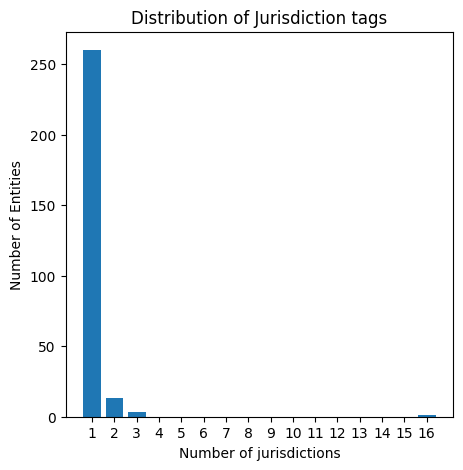

jurisdictions
1     260
2      13
3       3
16      1
Name: count, dtype: int64

In [88]:
# Compute the comma count for each value in the "jurisdictions" column
all_actors_in_flow_data = flows_df.src_id.value_counts().index.union(flows_df.dst_id.value_counts().index)
filtered_actors = actors_df[actors_df.id.str.lower().isin(all_actors_in_flow_data)]
comma_count_stats = filtered_actors['jurisdictions'].apply(lambda x: str(x).count(',')+1).value_counts().sort_index()

plt.figure(figsize=(5, 5)) 
plt.bar(comma_count_stats.index, comma_count_stats.values)
plt.xlabel('Number of jurisdictions')
plt.ylabel('Number of Entities')
plt.xticks(range(1, max(comma_count_stats.index) + 1), range(1, max(comma_count_stats.index) + 1))
plt.title('Distribution of Jurisdiction tags')
plt.show()

comma_count_stats

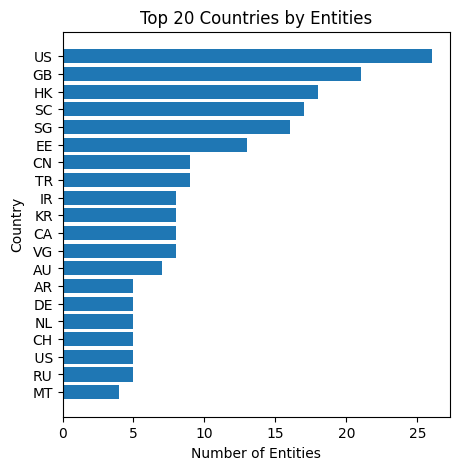

In [103]:
# Check distribution of jurisdictions
actors_jurisdictions = filtered_actors.assign(jurisdictions=filtered_actors.jurisdictions.str.split(','))
actors_jurisdictions = actors_jurisdictions.explode('jurisdictions')
jurisdiction_distribution = actors_jurisdictions.jurisdictions.value_counts().head(20)

plt.figure(figsize=(5, 5)) 
plt.barh(jurisdiction_distribution.index[::-1], jurisdiction_distribution.values[::-1])
plt.xlabel('Number of Entities')
plt.ylabel('Country')
#plt.xticks(range(1, 25), range(1, 25))
plt.title('Top 20 Countries by Entities')
plt.show()

who has 16 jurisdictions????

In [56]:
actors_df[actors_df['jurisdictions'].str.count(',') == 15]

,id,uri,label,jurisdictions,categories
35,binance,binance.com,"Binance (US, DEX)","AE, AU, BH, CA, CY, ES, FR, IT, KY, KZ, LT, MT...","defi_dex, exchange, mining_service, organization"


In [57]:
actors_df[actors_df['id'].str.contains("inance")== True]

,id,uri,label,jurisdictions,categories
35,binance,binance.com,"Binance (US, DEX)","AE, AU, BH, CA, CY, ES, FR, IT, KY, KZ, LT, MT...","defi_dex, exchange, mining_service, organization"


In which timeframe was the flow data collected?

In [58]:
# Flow data from - to
print(f'Flow data recorded from {flows_df.date.min()} to {flows_df.date.max()}')

Flow data recorded from 2011-08-02 to 2023-04-12


In [59]:
print(f'Flows before merging actor data {flows_df.shape[0]}')
merged_df = pd.merge(flows_df, actors_df.add_prefix('src_'), on='src_id', how='inner')
merged_df = pd.merge(merged_df, actors_df.add_prefix('dst_'), on='dst_id', how='inner')
print(f'Flows after merging actor data {merged_df.shape[0]}')
display(merged_df.head())

Flows before merging actor data 1709152
Flows after merging actor data 1677919


,src_id,dst_id,value_asset,value_USD,date,src_uri,src_label,src_jurisdictions,src_categories,dst_uri,dst_label,dst_jurisdictions,dst_categories
0,1coin,bitfinex,129990000,747.529257,2014-06-24,1coin.io,1Coin,"CA, US",exchange,bitfinex.com,Bitfinex,VG,exchange
1,1coin,bitfinex,546590000,3494.690488,2014-06-30,1coin.io,1Coin,"CA, US",exchange,bitfinex.com,Bitfinex,VG,exchange
2,allcrypt,bitfinex,1795821,11.070697,2014-05-30,www.allcrypt.com,Allcrypt,US,"exchange, service",bitfinex.com,Bitfinex,VG,exchange
3,allcrypt,bitfinex,3787360,22.271949,2014-06-16,www.allcrypt.com,Allcrypt,US,"exchange, service",bitfinex.com,Bitfinex,VG,exchange
4,allcrypt,bitfinex,4939000,29.067077,2014-06-20,www.allcrypt.com,Allcrypt,US,"exchange, service",bitfinex.com,Bitfinex,VG,exchange


In [60]:
# merge in btc course data
merged_df = pd.merge(merged_df,btc_price_data,on="date",how='inner')

In [61]:
# Types
merged_df['date'] = pd.to_datetime(merged_df['date'])

lets see how much of the traffic is from or to binance

In [62]:
# calc overall traffic per year
yearly = merged_df.groupby(["year"])["value_USD"].sum().reset_index()
yearly.rename(columns={"value_USD":"value_usd_with"},inplace=True)

yearly_without_binance = merged_df[merged_df["src_label"].str.contains("inance") == False]
yearly_without_binance = yearly_without_binance[yearly_without_binance["dst_label"].str.contains("inance") == False]

yearly["value_usd_without"] = yearly_without_binance.groupby(["year"])["value_USD"].sum().reset_index()["value_USD"]
yearly["binance portion"] = 1-(yearly["value_usd_without"]/yearly["value_usd_with"])

display(yearly)

,year,value_usd_with,value_usd_without,binance portion
0,2011,5.670567e+03,5.670567e+03,0.000000
1,2012,1.000773e+05,1.000773e+05,0.000000
2,2013,2.298649e+07,2.298649e+07,0.000000
3,2014,9.601529e+07,9.601529e+07,0.000000
4,2015,1.004441e+08,1.004441e+08,0.000000
5,2016,1.487341e+08,1.487341e+08,0.000000
6,2017,1.257284e+09,1.065114e+09,0.152846
7,2018,3.124788e+09,1.428452e+09,0.542864
8,2019,2.500138e+09,1.263970e+09,0.494440
9,2020,5.950352e+09,2.582169e+09,0.566048


In [64]:
# Transform jurisdiction string into list element
merged_df = merged_df.assign(src_jurisdictions=merged_df.src_jurisdictions.str.split(','))
merged_df = merged_df.assign(dst_jurisdictions=merged_df.dst_jurisdictions.str.split(','))
# Create year column
merged_df['year'] = merged_df.date.dt.year

display(merged_df.tail())

# Split up amounts by number of src and dst countries
merged_df['src_value_asset'] = merged_df.apply(lambda row: row['value_asset'] / len(row['src_jurisdictions']) if row['src_jurisdictions'] is not None else row['value_asset'], axis=1)
merged_df['dst_value_asset'] = merged_df.apply(lambda row: row['value_asset'] / len(row['dst_jurisdictions']) if row['dst_jurisdictions'] is not None else row['value_asset'], axis=1)
merged_df['src_value_USD'] = merged_df.apply(lambda row: row['value_USD'] / len(row['src_jurisdictions']) if row['src_jurisdictions'] is not None else row['value_USD'], axis=1)
merged_df['dst_value_USD'] = merged_df.apply(lambda row: row['value_USD'] / len(row['dst_jurisdictions']) if row['dst_jurisdictions'] is not None else row['value_USD'], axis=1)

# Create separate columns for each jurisdiction (if we want to split the amounts we have to split amount before)
merged_df = merged_df.explode('dst_jurisdictions')
merged_df = merged_df.explode('src_jurisdictions')

# Strip whitespace
merged_df.dst_jurisdictions = merged_df.dst_jurisdictions.str.strip()
merged_df.src_jurisdictions = merged_df.src_jurisdictions.str.strip()
# Remove flows which aren't x-border
merged_df = merged_df[merged_df['dst_jurisdictions'] != merged_df['src_jurisdictions']]

#display(merged_df.groupby(['year', 'dst_jurisdictions'])["open"].max())
# divide by btc value
# Do we really need this? Isn't value_asset already the number of tokens?
merged_df["value_BTC"] = merged_df["value_USD"] / merged_df["high"]

# Group by year and juristicion
dst_amounts = merged_df.groupby(['year', 'dst_jurisdictions'])[['value_USD', 'dst_value_asset', 'dst_value_USD', 'value_BTC',"src_label","dst_label"]].sum().reset_index()
dst_amounts = dst_amounts.rename(columns={"dst_jurisdictions":"jurisdictions"})

src_amounts = merged_df.groupby(['year', 'src_jurisdictions'])[['value_USD', 'src_value_asset', 'src_value_USD', 'value_BTC',"src_label","dst_label"]].sum().reset_index()
src_amounts = src_amounts.rename(columns={"src_jurisdictions":"jurisdictions"})

display(dst_amounts)
display(src_amounts)

,src_id,dst_id,value_asset,value_USD,date,src_uri,src_label,src_jurisdictions,src_categories,dst_uri,dst_label,dst_jurisdictions,dst_categories,high,year,src_value_asset,dst_value_asset,src_value_USD,dst_value_USD,value_BTC
260686,bitcoinde,orderbook,297000000,40.264289,2012-12-11,bitcoin.de,bitcoin.de,[DE],exchange,orderbook.net,Orderbook,[US],exchange,13.181821,2012,2.970000e+08,2.970000e+08,40.264289,40.264289,3.054532
260687,btce,cavirtex,743259999,43.587738,2011-09-11,btc-e.com,Btc-E,[AU],exchange,cavirtex.com,Cavirtex,[CA],exchange,5.951316,2011,7.432600e+08,7.432600e+08,43.587738,43.587738,7.324050
260688,btce,cavirtex,7484000000,319.776358,2011-10-07,btc-e.com,Btc-E,[AU],exchange,cavirtex.com,Cavirtex,[CA],exchange,4.567777,2011,7.484000e+09,7.484000e+09,319.776358,319.776358,70.007006
260689,btce,virwox,27320360,0.677518,2011-11-27,btc-e.com,Btc-E,[AU],exchange,virwox.com,Virwox,[AT],exchange,2.603560,2011,2.732036e+07,2.732036e+07,0.677518,0.677518,0.260227
260690,cavirtex,bitcoinica,193000000,5.351890,2011-10-26,cavirtex.com,Cavirtex,[CA],exchange,www.bitcoinica.com,Bitcoinica,[NZ],exchange,2.873687,2011,1.930000e+08,1.930000e+08,5.351890,5.351890,1.862377


,year,jurisdictions,value_USD,dst_value_asset,dst_value_USD,value_BTC,src_label,dst_label
0,2011,AT,3.304020e+02,1.049084e+10,3.304020e+02,96.264235,Btc-EBtc-EBtc-E,VirwoxVirwoxVirwox
1,2011,AU,1.213176e+03,3.726010e+10,1.213176e+03,368.918549,VircurexVircurexbitcoin.deBtccBtccCavirtexCavi...,Btc-EBtc-EBtc-EBtc-EBtc-EBtc-EBtc-EBtc-EBtc-E
2,2011,BZ,2.989268e+01,7.573903e+08,2.989268e+01,6.535206,Btc-E,Vircurex
3,2011,CA,4.165230e+02,1.049526e+10,4.165230e+02,94.021394,Btc-EBtc-EBtc-EBtc-E,CavirtexCavirtexCavirtexCavirtex
4,2011,CN,2.989268e+01,7.573903e+08,2.989268e+01,6.535206,Btc-E,Vircurex
...,...,...,...,...,...,...,...,...
515,2023,TW,6.800703e+06,2.523528e+10,6.800703e+06,267.257992,"Binance (US, DEX)Binance (US, DEX)Binance (US,...",Max MaicoinMax MaicoinMax MaicoinMax MaicoinMa...
516,2023,US,5.836787e+09,2.528403e+13,5.836787e+09,264263.182738,bitcoin.deBitforexBitGlobal (fka Bithumb)BitME...,"Binance (US, DEX)Binance (US, DEX)Binance (US,..."
517,2023,VG,1.846449e+07,6.962437e+10,1.846449e+07,723.116566,Crypto.comCrypto.comCrypto.comTradeOgreBinance...,LBankLBankLBankLBankBTSEBTSEBTSEBTSEBTSEBTSEBT...
518,2023,VN,2.856750e+04,1.189241e+08,2.856750e+04,1.269132,"Binance (US, DEX)Binance (US, DEX)Binance (US,...",VindaxVindaxVindaxVindaxVindaxVindaxVindaxVind...


,year,jurisdictions,value_USD,src_value_asset,src_value_USD,value_BTC,src_label,dst_label
0,2011,AT,2.778538e+03,7.049400e+10,2.778538e+03,609.227868,VirwoxVirwox,TheRockTradingBtcc
1,2011,AU,9.275158e+02,2.651036e+10,9.275158e+02,236.652345,Btc-EBtc-EBtc-EBtc-EBtc-EBtc-EBtc-EBtc-EBtc-EB...,BitstampBtccBitcoinicaBtccBtccVircurexVircurex...
2,2011,BZ,1.475024e+02,3.554098e+09,1.475024e+02,30.936785,VircurexVircurex,Btc-EBtc-E
3,2011,CA,5.101930e+01,1.701000e+09,5.101930e+01,14.056460,CavirtexCavirtexCavirtexCavirtexCavirtex,BitcoinicaBitcoinicaBtc-EBtc-EBitcoinica
4,2011,CN,1.475024e+02,3.554098e+09,1.475024e+02,30.936785,VircurexVircurex,Btc-EBtc-E
...,...,...,...,...,...,...,...,...
495,2023,TR,2.092071e+08,9.507812e+11,2.092071e+08,9927.581349,BtcTurk PROBtcTurk PROBtcTurk PROBtcTurk PROBt...,"HuobiBinance (US, DEX)Binance (US, DEX)Binance..."
496,2023,TW,7.017710e+07,2.893594e+11,7.017710e+07,2946.629933,Max MaicoinMax MaicoinMax MaicoinMax MaicoinMa...,"Binance (US, DEX)Binance (US, DEX)Binance (US,..."
497,2023,US,2.881331e+09,1.263497e+13,2.881331e+09,132634.727436,"Binance (US, DEX)Binance (US, DEX)CoinbaseBina...","BitstampCexCexHuobiHuobiHuobiBinance (US, DEX)..."
498,2023,VG,9.012389e+05,3.892722e+09,9.012389e+05,39.570855,BKEXBKEXBKEXBKEXBKEXBKEXBKEXBKEXBKEXBKEXBKEXBK...,"CoinbaseCoinbaseBinance (US, DEX)Binance (US, ..."


In [65]:
# Number of flows after merging and filtering for different locations
print(f'Number of rows in the flow dataset {merged_df.shape[0]}')

Number of rows in the flow dataset 940287


### Frequency of jurisidictions in the flow data

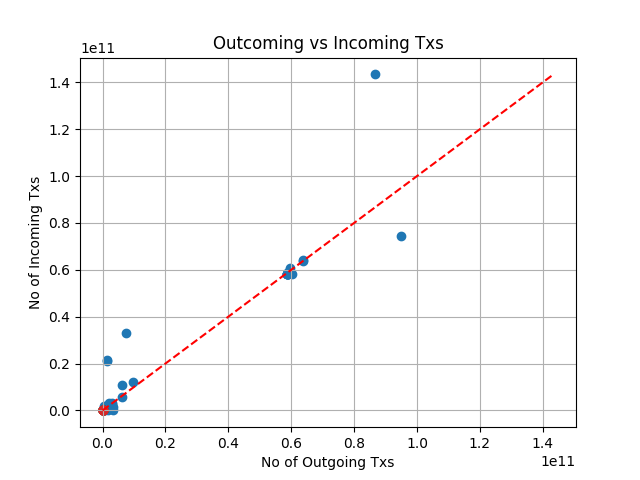

,count_x,count_y
US,99146,82843
SC,81817,74956
GB,53979,61205
SG,47055,55383
MT,46630,43594
KY,44735,38056
ZA,34714,37585
NZ,31399,29047
IT,31252,27046
LT,31228,28514


,count_x,count_y
US,99146,82843
SC,81817,74956
GB,53979,61205
SG,47055,55383
MT,46630,43594
KY,44735,38056
ZA,34714,37585
NZ,31399,29047
IT,31252,27046
LT,31228,28514


,count_x,count_y
US,99146,82843
SC,81817,74956
GB,53979,61205
SG,47055,55383
MT,46630,43594
KY,44735,38056
ZA,34714,37585
AU,30278,36502
CY,28600,29115
NZ,31399,29047


In [66]:
src_juri_freq = merged_df.src_jurisdictions.value_counts().head(20)
dst_juri_freq = merged_df.dst_jurisdictions.value_counts().head(20)
merged_freq = pd.merge(src_juri_freq, dst_juri_freq, left_index=True, right_index=True, how='inner')
plt.scatter(x=merged_freq.count_x, y=merged_freq.count_y)
plt.xlabel('No of Outgoing Txs')
plt.ylabel('No of Incoming Txs')
plt.title('Outcoming vs Incoming Txs')
plt.grid(True)
line = np.linspace(min(merged_freq.count_x), max(merged_freq.count_y), 100)
plt.plot(line, line, color='r', linestyle='--')
plt.show()

display(merged_freq)
display(merged_freq.sort_values(by='count_x', ascending=False))
display(merged_freq.sort_values(by='count_y', ascending=False))

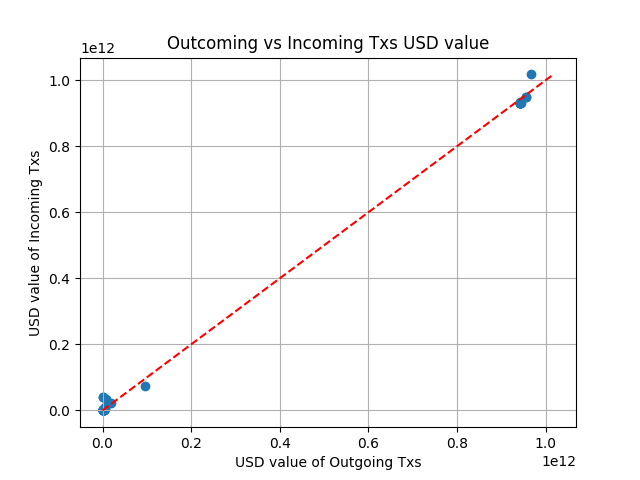

,src_value_USD,dst_value_USD
US,9.660068e+11,1.017317e+12
KY,9.555987e+11,9.483441e+11
MT,9.555416e+11,9.483905e+11
AE,9.441939e+11,9.314120e+11
ZA,9.418716e+11,9.342099e+11
...,...,...
VC,1.788847e+05,4.125093e+04
IN,1.545862e+05,1.109911e+04
VN,4.026151e+04,1.491355e+06
GI,1.427420e+04,7.009536e+06


,src_value_USD,dst_value_USD
US,9.660068e+11,1.017317e+12
MT,9.555416e+11,9.483905e+11
KY,9.555987e+11,9.483441e+11
ZA,9.418716e+11,9.342099e+11
NZ,9.411249e+11,9.321884e+11
...,...,...
HR,2.538962e+05,1.911880e+05
IE,4.339215e+06,1.285809e+05
VC,1.788847e+05,4.125093e+04
BE,4.569300e+03,1.523813e+04


In [67]:
# Total value of incoming / outgoing tx
src_juri_sum = merged_df.groupby('src_jurisdictions')['src_value_USD'].sum()
dst_juri_sum = merged_df.groupby('dst_jurisdictions')['dst_value_USD'].sum()
merged_sum = pd.merge(src_juri_sum, dst_juri_sum, left_index=True, right_index=True, how='inner')
fig, ax = plt.subplots()
scatter = ax.scatter(x=merged_sum.src_value_USD, y=merged_sum.dst_value_USD)
plt.xlabel('USD value of Outgoing Txs')
plt.ylabel('USD value of Incoming Txs')
plt.title('Outcoming vs Incoming Txs USD value')
plt.grid(True)

line = np.linspace(min(merged_sum.src_value_USD), max(merged_sum.dst_value_USD), 100)
plt.plot(line, line, color='r', linestyle='--')
plt.show()

display(merged_sum.sort_values(by='src_value_USD', ascending=False))
display(merged_sum.sort_values(by='dst_value_USD', ascending=False))

### Trading Pairs frequency

<Axes: ylabel='trading_pairs'>

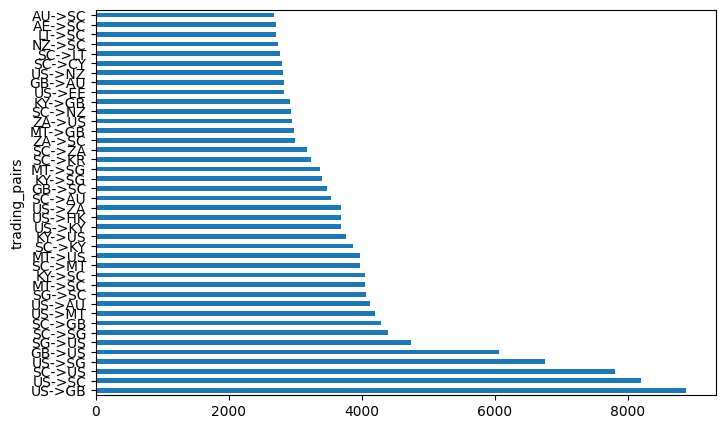

In [76]:
merged_df['trading_pairs'] = merged_df['src_jurisdictions'] + '->' + merged_df['dst_jurisdictions']

merged_df.trading_pairs.value_counts().head(40).plot.barh(figsize=(8, 5))

# Correlations

In [30]:
# Prepare tax haven data
cthi_country = pd.merge(cthi, country_codes, left_on='Country', right_on='name', how='inner')

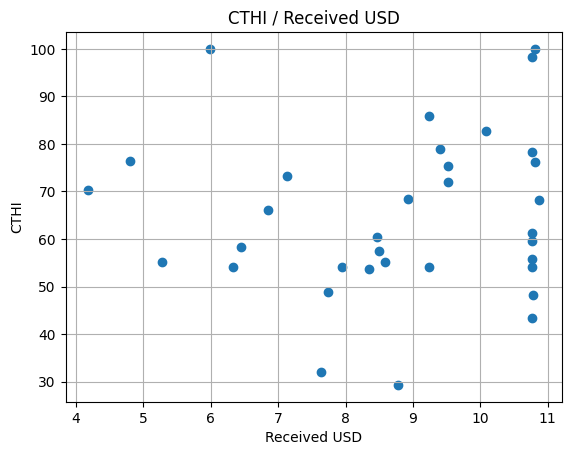

In [33]:
# CTHI (Tax Haven Score)
flow_data = merged_df.copy()
dst_juri_sum = merged_df.groupby('dst_jurisdictions')['dst_value_USD'].sum()
receivers_cthi = pd.merge(dst_juri_sum, cthi_country, left_on='dst_jurisdictions', right_on='alpha-2', how='inner')

fig, ax = plt.subplots()
scatter = ax.scatter(x=np.log10(receivers_cthi.dst_value_USD), y=receivers_cthi['Haven Score'])
plt.xlabel('Received USD')
plt.ylabel('CTHI')
plt.title('CTHI / Received USD')
plt.grid(True)

In [35]:
# Prepare CPI
cpi_country = pd.merge(cpi, country_codes, left_on='Country', right_on='name', how='inner')

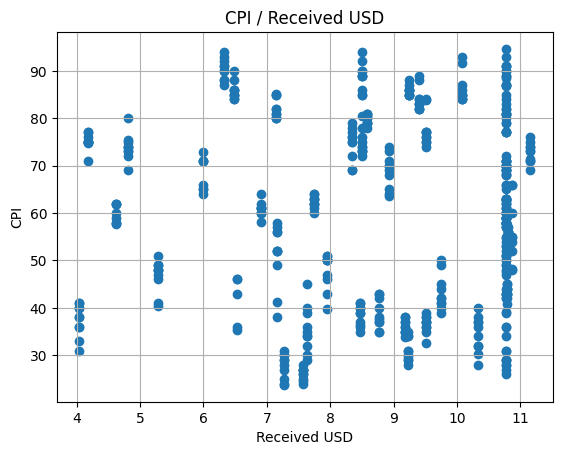

In [38]:
flow_data = merged_df.copy()
dst_juri_sum = merged_df.groupby('dst_jurisdictions')['dst_value_USD'].sum()
receivers_cpi = pd.merge(dst_juri_sum, cpi_country, left_on='dst_jurisdictions', right_on='alpha-2', how='inner')

fig, ax = plt.subplots()
scatter = ax.scatter(x=np.log10(receivers_cpi.dst_value_USD), y=receivers_cpi['CPI Score'])
plt.xlabel('Received USD')
plt.ylabel('CPI')
plt.title('CPI / Received USD')
plt.grid(True)

In [41]:
# Prepare GDP
gdp_country = pd.merge(gdp, country_codes, left_on='Country Code', right_on='alpha-3', how='inner')

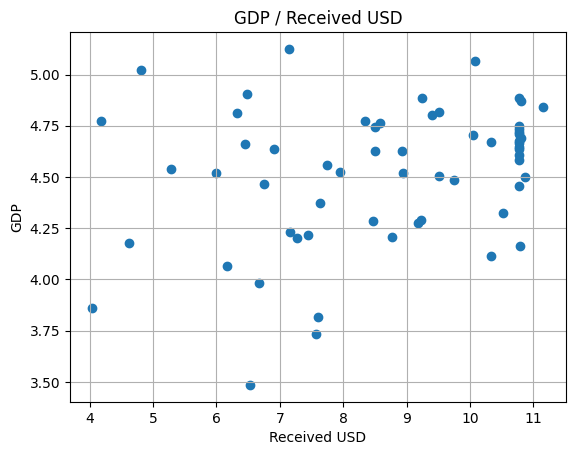

In [54]:
flow_data = merged_df.copy()
dst_juri_sum = merged_df.groupby('dst_jurisdictions')['dst_value_USD'].sum()
receivers_gdp = pd.merge(dst_juri_sum, gdp_country, left_on='dst_jurisdictions', right_on='alpha-2', how='inner')

fig, ax = plt.subplots()
scatter = ax.scatter(x=np.log10(receivers_gdp.dst_value_USD), y=np.log10(receivers_gdp['2021']))
plt.xlabel('Received USD')
plt.ylabel('GDP')
plt.title('GDP / Received USD')
plt.grid(True)

In [56]:
# Prepare Population
population_country = pd.merge(population, country_codes, left_on='Country Code', right_on='alpha-3', how='inner')

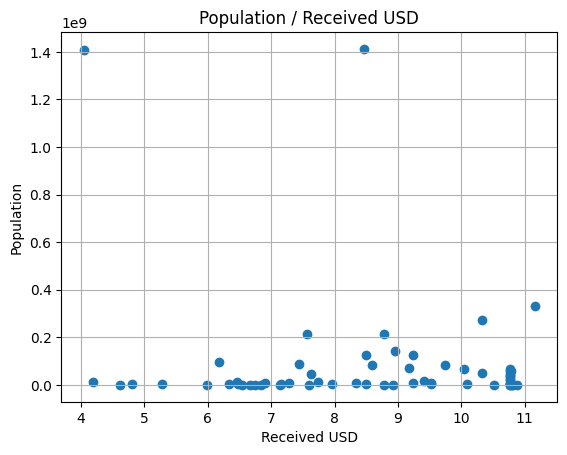

In [59]:
flow_data = merged_df.copy()
dst_juri_sum = merged_df.groupby('dst_jurisdictions')['dst_value_USD'].sum()
population_gdp = pd.merge(dst_juri_sum, population_country, left_on='dst_jurisdictions', right_on='alpha-2', how='inner')

fig, ax = plt.subplots()
scatter = ax.scatter(x=np.log10(population_gdp.dst_value_USD), y=population_gdp['2021'])
plt.xlabel('Received USD')
plt.ylabel('Population')
plt.title('Population / Received USD')
plt.grid(True)

In [52]:
gdp_country['2021']

0      42698.359872
1       1665.805842
2       6491.125578
3      15814.411571
4               NaN
           ...     
210     6079.764271
211             NaN
212    14624.415171
213     3555.920229
214     2323.687257
Name: 2021, Length: 215, dtype: float64

### How does the general trend look like?

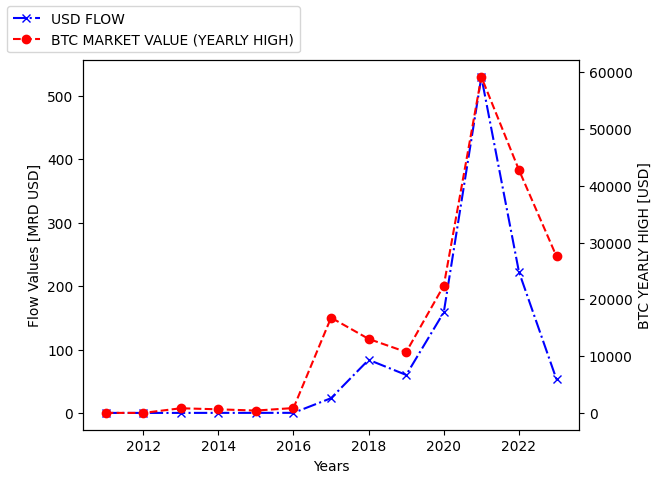

In [77]:
def test_plot(flow_data, btc_data):
    _flow_data = flow_data.groupby('year')["src_value_USD"].sum()/1000000000
    _btc_data = btc_data.groupby('year')["high"].max()

    fig, ax1 = plt.subplots()

    # Plotting the bar plot
    ax1.plot(_flow_data.index, _flow_data.values, color='blue',marker="x",linestyle="dashdot",label="USD FLOW")
    ax1.set_ylabel('Flow Values [MRD USD]')
    ax2 = ax1.twinx()

    # Plotting the line plot
    ax2.plot(_flow_data.index, _btc_data.values, color='red', marker='o', linestyle="dashed",label="BTC MARKET VALUE (YEARLY HIGH)")
    ax2.set_ylabel('BTC YEARLY HIGH [USD]')
    ax1.set_xlabel('Years')
    fig.legend(loc='upper left',ncol=1)

    #plt.tight_layout()

test_plot(src_amounts, btc_price_data)
#test_plot(dst_amounts)

looks like Flow value and the BTC market value correlate - does that mean that the amount of BTC flowing (=flow value/ btc market value) is constant? Lets see

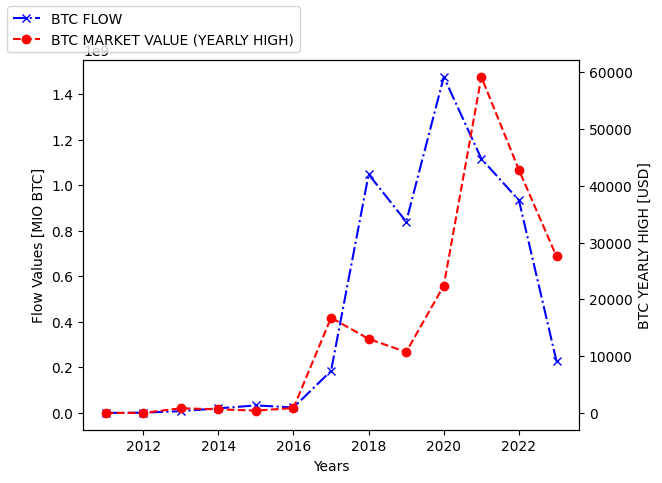

In [78]:
def test_plot2(flow_data,btc_data):
    # TODO: can we use the assets or should we use BTC_value?
    _flow_data = flow_data.groupby('year')["src_value_asset"].sum()/1000000
    _btc_data = btc_data.groupby('year')["high"].max()

    fig, ax1 = plt.subplots()

    # Plotting the bar plot
    ax1.plot(_flow_data.index, _flow_data.values, color='blue',marker="x",linestyle="dashdot",label="BTC FLOW")
    ax1.set_ylabel('Flow Values [MIO BTC]')
    ax2 = ax1.twinx()

    # Plotting the line plot
    ax2.plot(_flow_data.index, _btc_data.values, color='red', marker='o', linestyle="dashed",label="BTC MARKET VALUE (YEARLY HIGH)")
    ax2.set_ylabel('BTC YEARLY HIGH [USD]')
    ax1.set_xlabel('Years')
    fig.legend(loc='upper left',ncol=1)

test_plot2(src_amounts,btc_price_data)

how are the flows distributed over the jurisdictions?

In [79]:
def plot_juri_bars(data1,data2,l1,l2,year,label):
    #x = dst_amounts["jurisdictions"].unique()
    data1 = data1.sort_values("jurisdictions",ascending=False)
    filtered_data1 = [d for d in zip(data1['year'],data1['jurisdictions'], data1['src_value_USD']/1000000000) if d[0] == year]

    data2 = data2.sort_values("jurisdictions",ascending=False)
    filtered_data2 = [d for d in zip(data2['year'],data2['jurisdictions'], data2['dst_value_USD']/1000000000) if d[0] == year]

    #display(filtered_data)
    # Separate the x and y values
    x1 = [d[1] for d in filtered_data1]
    y1 = [d[2] for d in filtered_data1]

    x2 = [d[1] for d in filtered_data2]
    y2 = [d[2] for d in filtered_data2]

    fig, (ax1,ax2)= plt.subplots(2,1,figsize=(10,5))

    # Plot the bar chart
    ax1.bar(x1, y1)
    # Set labels and title
    ax1.set_xlabel('Jurisdictions')
    ax1.set_ylabel(f'{l1} Value (MRD USD)')

    # Plot the bar chart
    ax2.bar(x2, y2)
    # Set labels and title
    ax2.set_xlabel('Jurisdictions')
    ax2.set_ylabel(f'{l2} Value (MRD USD)')

    # Rotate x-axis labels for better visibility
    ax1.tick_params(axis='x', rotation=90)
    ax2.tick_params(axis='x', rotation=90)

    # Add a label to the plot
    plt.suptitle(label, fontsize=14)

   
    # Display the plot
    plt.show()

interact(plot_juri_bars,data1=fixed(src_amounts),data2=fixed(dst_amounts),l1=fixed("Source"),l2=fixed("Destination"),year=(2012,2022,1),label=fixed("Yearly flow values by jursidictions"))

interactive(children=(IntSlider(value=2017, description='year', max=2022, min=2012), Output()), _dom_classes=(…

<function __main__.plot_juri_bars(data1, data2, l1, l2, year, label)>

they are all prettymuch "the same" - maybe because binance is in just those juris? lets see

In [80]:
src_filterd = src_amounts[src_amounts["src_label"].str.contains("inance") == False]
src_filterd = src_filterd[src_filterd["dst_label"].str.contains("inance") == False]

dst_filterd = dst_amounts[dst_amounts["src_label"].str.contains("inance") == False]
dst_filterd = dst_filterd[dst_filterd["dst_label"].str.contains("inance") == False]


interact(plot_juri_bars,data1=fixed(src_filterd),data2=fixed(dst_filterd),l1=fixed("Source"),l2=fixed("Destination"),year=(2012,2022,1),label=fixed("Yearly flow values by jursidictions without binance"))

interactive(children=(IntSlider(value=2017, description='year', max=2022, min=2012), Output()), _dom_classes=(…

<function __main__.plot_juri_bars(data1, data2, l1, l2, year, label)>

In [81]:
result = src_amounts.copy()
result['value_USD'] = src_amounts['src_value_USD'].sub(dst_amounts['dst_value_USD'], axis=0)
#interact(plot_juri_bars,data1=fixed(result),data2=fixed(result),l1=fixed("Source"),l2=fixed("Destination"),year=(2012,2022,1),label=fixed("Holdings by jurisdictions in"))

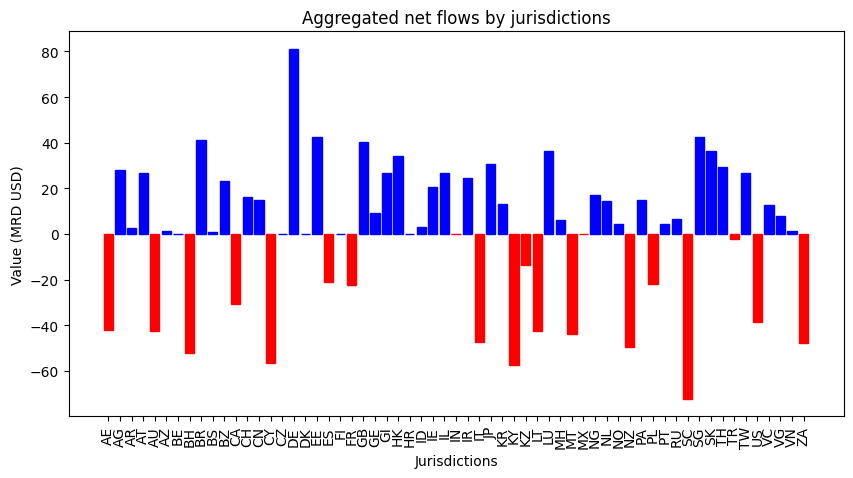

,jurisdictions,value_USD
0,AE,-42.206017
1,AG,28.169632
2,AR,2.710224
3,AT,26.709184
4,AU,-42.434353
...,...,...
56,US,-38.407672
57,VC,12.701548
58,VG,7.912514
59,VN,1.315664


In [94]:
result = src_amounts.copy()
result['value_USD'] = dst_amounts['dst_value_USD'].sub(src_amounts['src_value_USD'], axis=0)

result = result.groupby(['jurisdictions'])['value_USD'].sum().reset_index()
result = result.sort_values("jurisdictions",ascending=True)
result["value_USD"] = result["value_USD"] / 10**9

plt.figure(figsize=(10, 5))

# Plot the bar chart
bars = plt.bar(result['jurisdictions'], result['value_USD'])

# Set labels and title
plt.xlabel('Jurisdictions')
plt.ylabel('Value (MRD USD)')
plt.title('Aggregated net flows by jurisdictions')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Color the bars based on a condition
for bar, value in zip(bars, result['value_USD']):
    if value < 0:
        bar.set_color('red')
    else:
        bar.set_color('blue')

# Display the plot
plt.show()
display(result)

In [104]:
def plot_net_flows_by_year(src_amounts,dst_amounts,year):
    y_result = src_amounts[src_amounts['year'] == year]
    y_result['value_USD'] = dst_amounts['dst_value_USD'].sub(src_amounts['src_value_USD'], axis=0)

    y_result = y_result.groupby(['jurisdictions'])['value_USD'].sum().reset_index()
    y_result = y_result.sort_values("jurisdictions",ascending=True)
    y_result["value_USD"] = y_result["value_USD"] / 10**9
    
    plt.figure(figsize=(10, 5))

    # Plot the bar chart
    bars = plt.bar(y_result['jurisdictions'], y_result['value_USD'])

    # Set labels and title
    plt.xlabel('Jurisdictions')
    plt.ylabel('Value (MRD USD)')
    plt.title('Aggregated net flows by jurisdictions ')

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=90)
    plt.grid(True)

    # Color the bars based on a condition
    for bar, value in zip(bars, y_result['value_USD']):
        if value < 0:
            bar.set_color('red')
        else:
            bar.set_color('blue')

    # Display the plot
    plt.show()

interact(plot_net_flows_by_year,src_amounts=fixed(src_amounts),dst_amounts=fixed(dst_amounts),year=(2012,2022,1))

interactive(children=(IntSlider(value=2017, description='year', max=2022, min=2012), Output()), _dom_classes=(…

<function __main__.plot_net_flows_by_year(src_amounts, dst_amounts, year)>

## What do the flows look like on a map?

,alpha-2,value_USD
0,AE,-42.206017
1,AG,28.169632
2,AR,2.710224
3,AT,26.709184
4,AU,-42.434353
...,...,...
56,US,-38.407672
57,VC,12.701548
58,VG,7.912514
59,VN,1.315664


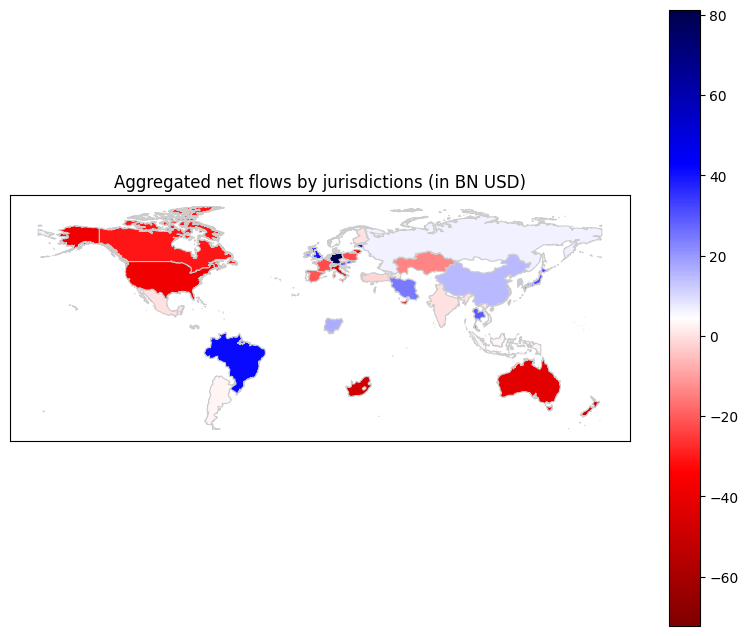

In [98]:
display(result)
result.rename(columns={'jurisdictions':'alpha-2'},inplace=True)
country_codes = pd.read_csv('data/country_codes.csv')
country_codes = country_codes[['alpha-2','alpha-3']]
c_merged_df= pd.merge(result, country_codes,on='alpha-2',how='inner')
c_merged_df.rename(columns={'alpha-2':'ISO'},inplace=True)

map_data = gpd.read_file('shapefile/World_Countries__Generalized_.shp')

c_merged_data = map_data.merge(c_merged_df, on='ISO')
fig, ax = plt.subplots(figsize=(10, 8))

c_merged_data.plot(column='value_USD', cmap='seismic_r', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Holdings')
plt.xticks([])
plt.yticks([])
plt.title('Aggregated net flows by jurisdictions (in BN USD)')
plt.show()

In [85]:
# TODO: Merge with GDP Data
# Merge country codes first
print(f'Dest Rows before merge: {dst_amounts.shape[0]}')
dst = pd.merge(dst_amounts, country_codes[['alpha-2', 'alpha-3', 'region', 'sub-region']], left_on='dst_jurisdictions', right_on='alpha-2', how='left')

print(f'Src rows before merge: {src_amounts.shape[0]}')
src = pd.merge(src_amounts, country_codes[['alpha-2', 'alpha-3', 'region', 'sub-region']], left_on='src_jurisdictions', right_on='alpha-2', how='inner')
#display(src.head())

# Now merge gdp data
dst = pd.merge(dst, gdp, left_on='alpha-3', right_on='Country Code', how='left')
print(f'Dest rows after merge: {dst.shape[0]}')

src = pd.merge(src, gdp, left_on='alpha-3', right_on='Country Code', how='inner')
print(f'Src rows after merge: {src.shape[0]}')

print(display(dst[dst['alpha-3'].isna()]))

Dest Rows before merge: 527


KeyError: "['region', 'sub-region'] not in index"